In [2]:
import ee
import geemap
!pip install xee
import xee
import xarray as xr
import numpy as np
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.2 MB/s eta 0:00:00


In [3]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-lavibas23',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)


In [4]:
map = geemap.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
roi = map.draw_last_feature.geometry()

roi


ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          79.440427,
                          5.747174
                        ],
                        [
                          79.440427,
                          9.947209
                        ],
                        [
                          82.39491,
                          9.947209
                        ],
                        [
                          82.39491,
                          5.747174
                        ],
                        [
                          79.440427,
                          5.747174
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [6]:
time_start = ee.Date('2016')
time_end = ee.Date('2024')
time_dif = time_end.difference(time_start, 'month').round()
time_list = ee.List.sequence(0, ee.Number(time_dif).subtract(1), 1).map(lambda x: time_start.advance(x, 'month'))
time_list

In [7]:
smap = (
    ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005")
    .select('soil_moisture_am')
    .filterDate(time_start, time_end)
)

smap.size()

In [8]:
def monthly(date, col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'month')
  img = col.filterDate(start_date, end_date).mean()
  return img.set('system:time_start', start_date.millis())

In [9]:
smap_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, smap)))

smap_monthly

In [10]:
ds = xr.open_dataset(
    smap_monthly,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.01,
    geometry = roi
)

ds

<xarray.Dataset> Size: 48MB
Dimensions:           (time: 96, lon: 295, lat: 420)
Coordinates:
  * time              (time) datetime64[ns] 768B 2016-01-01 ... 2023-12-01
  * lon               (lon) float64 2kB 79.45 79.46 79.47 ... 82.37 82.38 82.39
  * lat               (lat) float64 3kB 5.752 5.762 5.772 ... 9.922 9.932 9.942
Data variables:
    soil_moisture_am  (time, lon, lat) float32 48MB ...
Attributes:
    crs:      EPSG:4326

In [ ]:
# ssi, ssmi
# (sm_i - sm_mean) / (sm_std)


In [11]:
ds_mean = ds.mean(dim = 'time')

ds_mean

<xarray.Dataset> Size: 501kB
Dimensions:           (lon: 295, lat: 420)
Coordinates:
  * lon               (lon) float64 2kB 79.45 79.46 79.47 ... 82.37 82.38 82.39
  * lat               (lat) float64 3kB 5.752 5.762 5.772 ... 9.922 9.932 9.942
Data variables:
    soil_moisture_am  (lon, lat) float32 496kB nan nan nan nan ... nan nan nan

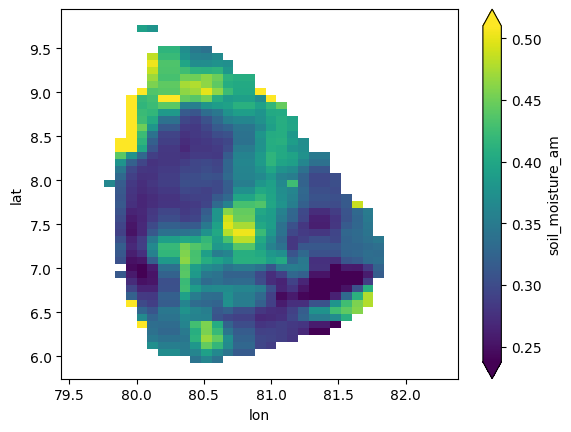

In [12]:
ds_mean.soil_moisture_am.plot(
    x = 'lon',
    y = 'lat',
    robust = True
)

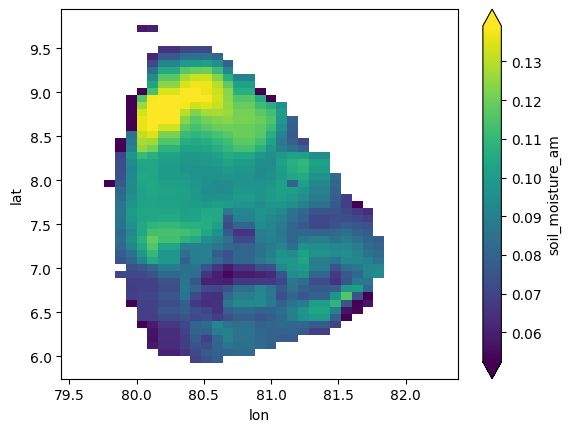

In [13]:
ds_std = ds.std(dim = 'time')

ds_std.soil_moisture_am.plot(
    x = 'lon',
    y = 'lat',
    robust = True
)

In [14]:
ssi = (ds - ds_mean) / ds_std

sub = ssi.sel(time = ssi.time.dt.year == 2019)
sub

<xarray.Dataset> Size: 6MB
Dimensions:           (time: 12, lon: 295, lat: 420)
Coordinates:
  * time              (time) datetime64[ns] 96B 2019-01-01 ... 2019-12-01
  * lon               (lon) float64 2kB 79.45 79.46 79.47 ... 82.37 82.38 82.39
  * lat               (lat) float64 3kB 5.752 5.762 5.772 ... 9.922 9.932 9.942
Data variables:
    soil_moisture_am  (time, lon, lat) float32 6MB nan nan nan ... nan nan nan

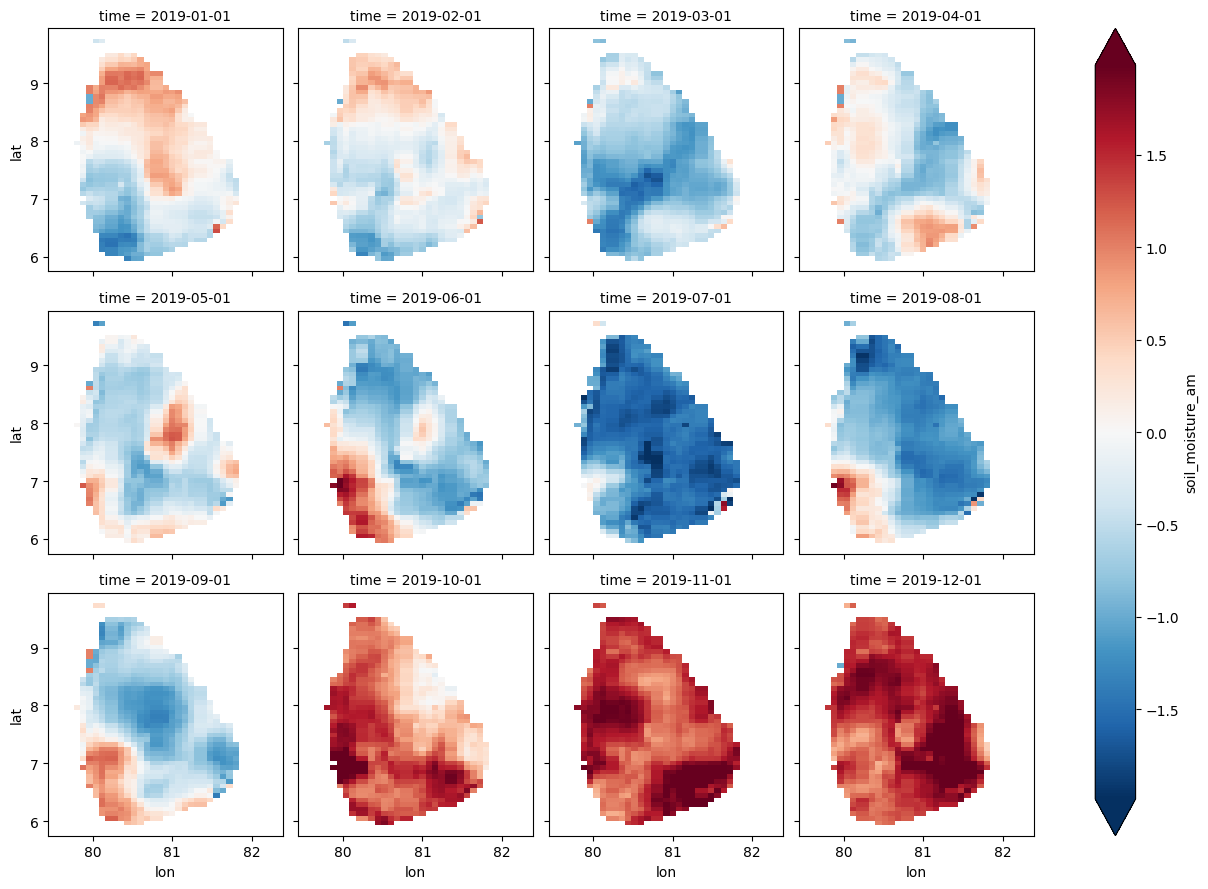

In [15]:
sub.soil_moisture_am.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 4,
    robust = True,
)


<xarray.Dataset> Size: 4MB
Dimensions:           (time: 8, lon: 295, lat: 420)
Coordinates:
  * lon               (lon) float64 2kB 79.45 79.46 79.47 ... 82.37 82.38 82.39
  * lat               (lat) float64 3kB 5.752 5.762 5.772 ... 9.922 9.932 9.942
  * time              (time) datetime64[ns] 64B 2016-12-31 ... 2023-12-31
Data variables:
    soil_moisture_am  (time, lon, lat) float32 4MB nan nan nan ... nan nan nan

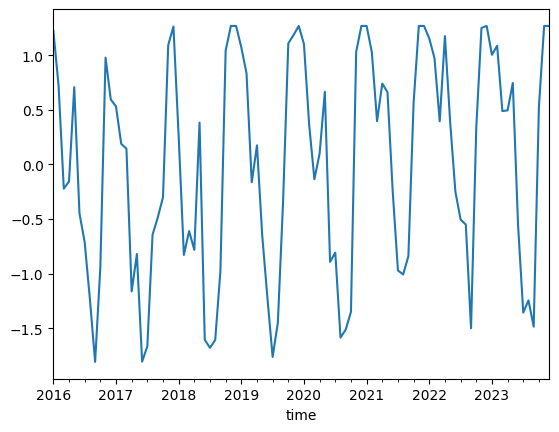

In [16]:
point = ssi.sel(lon = 80.55 , lat = 8.95, method = 'nearest')

point

df = point.to_dataframe()['soil_moisture_am']

df.plot()

ssi_annual = ssi.resample(time = 'YE').mean('time')

ssi_annual

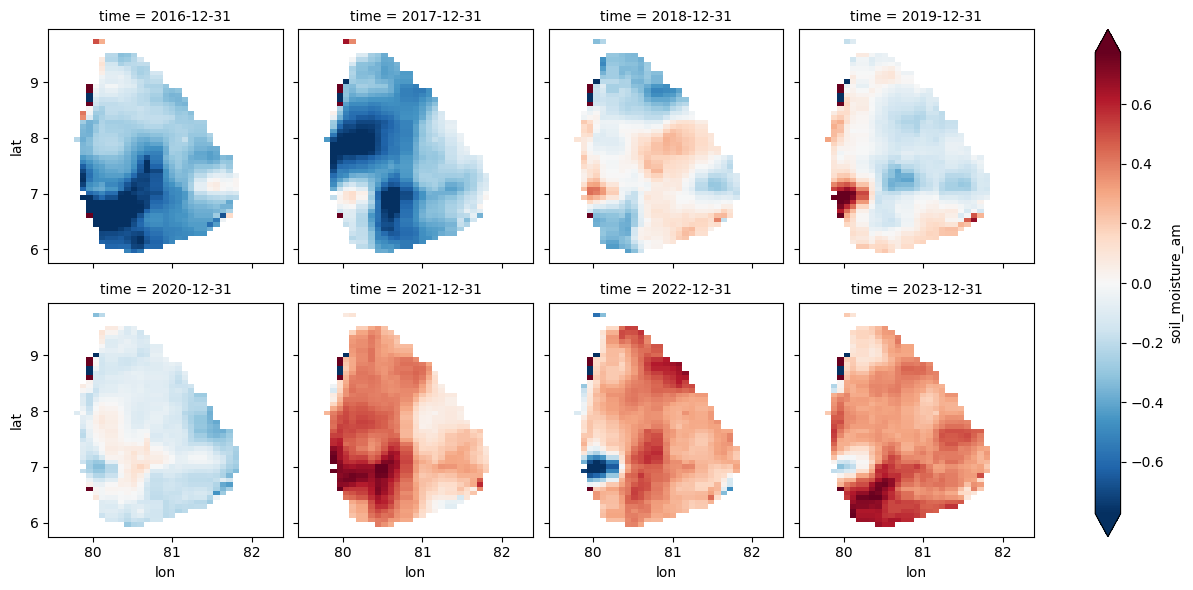

In [17]:
import matplotlib.pyplot as plt

ssi_plot = ssi_annual.soil_moisture_am.plot(
    x = 'lon',
    y = 'lat',
    robust = True,
    col = 'time',
    col_wrap = 4,
)


In [18]:
for ax in ssi_plot.axes.flat:
  ax.set_ylabel('')
  ax.set_xlabel('')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.title.set_fontsize(15)

plot_cbar = ssi_plot.cbar
plot_cbar.ax.tick_params(labelsize = 15)
plot_cbar.set_label('SSI', fontsize = 15)

plt.savefig('ssi_annual.png', dpi = 360, bbox_inches = 'tight')

<Figure size 640x480 with 0 Axes>